Модель рекуррентной сети с цепью нейросетевых моделей долгой кратковременной памяти c функцией активации гиперболический тангенс

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from math import  sin, tanh, cos
from tqdm import tqdm
from random import random

2023-01-02 00:01:50.727392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 00:01:54.051474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-02 00:01:54.051622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-02 00:01:54.051636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
seqLen = 20

batchSize = 10 

trainSize = 0.8

dataRange = np.linspace(0,200,1000) 
data = [[0.5*sin(2*i)-cos(2*i)+sin(i/2)] for i in dataRange ]


trainData = data[:int(trainSize*len(data))]
testData = data[int(trainSize*len(data)):]

trainTarget = trainData[seqLen:]

testDataRange = dataRange[int(trainSize*len(data)):]

train = tf.keras.utils.timeseries_dataset_from_array(
      data=trainData,
      targets=trainTarget,
      sequence_length=seqLen,
      batch_size=batchSize)

2023-01-02 00:01:56.761452: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-02 00:01:56.761575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hazner-x542un): /proc/driver/nvidia/version does not exist
2023-01-02 00:01:56.769300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


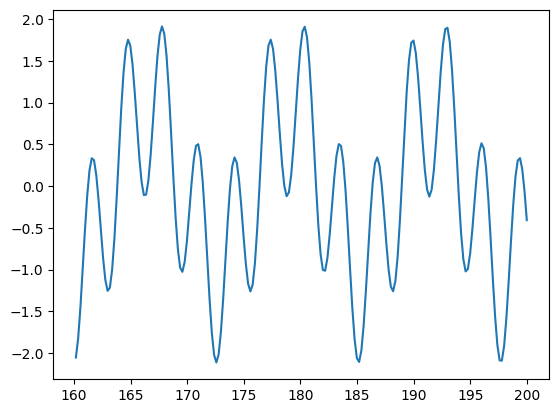

In [3]:
plt.plot(testDataRange, testData)


Архитектура LSTM – сети долгой краткосрочной памяти
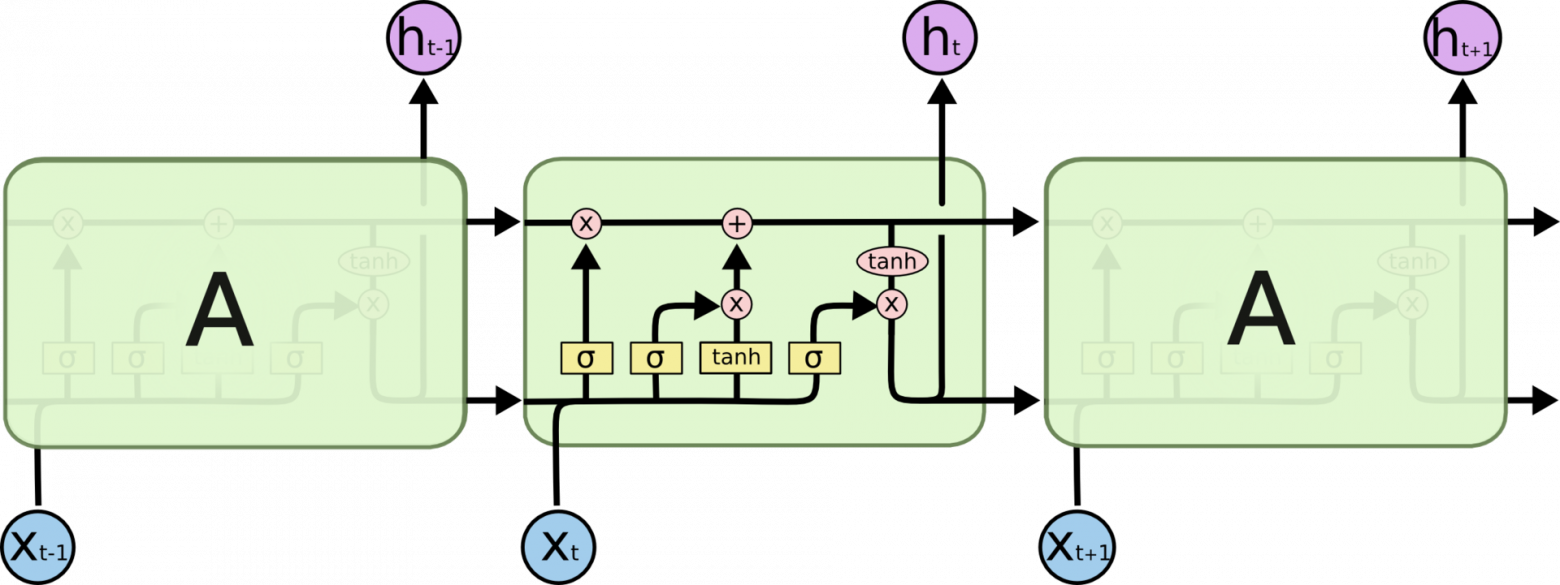

In [4]:
class LSTM:
    def __init__(self):
        self.model = tf.keras.models.Sequential([
                    tf.keras.layers.InputLayer(input_shape=(seqLen,1)),
                    tf.keras.layers.LSTM(10,activation ="tanh", return_sequences = False),
                    tf.keras.layers.Dense(units=1)
                    ])
        self.compile()
        
    def compile(self):
        self.model.compile(loss=tf.losses.Huber(),
            optimizer=tf.optimizers.Adam(learning_rate=0.01),
            metrics=[tf.metrics.MeanAbsoluteError()])

        self.model.build()
        self.model.summary()
        
    def train(self, data, epochs = 10):
        for _ in range(epochs):
            self.model.fit(train,
                          validation_data=None
                          )
    def test(self, test):
        rez = [test[i][0] for i in range(seqLen)]
        length = len(test) - seqLen
        start = [test[:seqLen]]
        for i in tqdm(range(length)):
            next = float(self.model.predict(start, verbose = 0)[0][0])
            start[0] = start[0][1:]
            start[0].append([next])
            rez.append(next)
            
        return rez
        

In [5]:
L = LSTM()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [9]:
L.train(train)


78/78 [==============================] - 1s 14ms/step - loss: 3.0733e-04 - mean_absolute_error: 0.0192


In [10]:
prediction = L.test(testData)

100%|██████████| 180/180 [00:20<00:00,  8.90it/s]


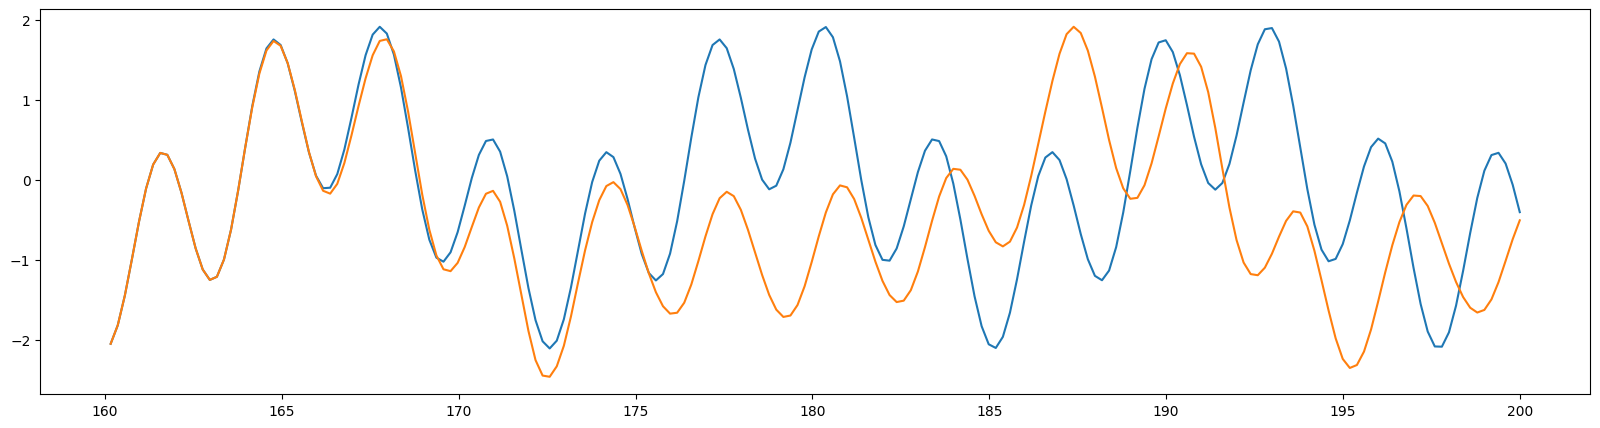

In [11]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(testDataRange, testData)
plt.plot(testDataRange, prediction)